In [2]:
"""
Loading the data for analysis
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_control = "logs/SLM-0.124B_final_control_model_log.txt"
path_rkld = "logs/SLM-0.124B_MiniLLM_KLD_log.txt"
path_first = "logs/SLM-0.124B_log.txt"
data_final = pd.read_csv(path_control, sep=" ", header=None, names=["index", "label", "value"])
data_first = pd.read_csv(path_first, sep=" ", header=None, names=["index", "label", "value"])
data_rkld = pd.read_csv(path_rkld, sep=" ", header=None, names=["index", "label", "value"])

control_train = data_final[data_final["label"] == "train"]
control_val = data_final[data_final["label"] == "val"]
control_hella = data_final[data_final["label"] == "hella"]
first_train = data_first[data_first["label"] == "train"]
first_val = data_first[data_first["label"] == "val"]
first_hella = data_first[data_first["label"] == "hella"]
rkld_train = data_rkld[data_rkld["label"] == "train"]
rkld_val = data_rkld[data_rkld["label"] == "val"]
rkld_hella = data_rkld[data_rkld["label"] == "hella"]

FileNotFoundError: [Errno 2] No such file or directory: 'logs/SLM-0.124B_log.txt'

## Abstract
This notebook is a research project that I conducted to test the efficacy of the results of [2] in their 2024 MiniLLM paper with what I will call "MicoLMs" (models with less than 200B parameters).

I first trained an entire 124M model with inspiration from Andrej Karpathy, GPT-3, and OLMo. I created a modular LM trained on the 10B token subset of finewebEDU from Hugging Face, as shown below. The model outperformed GPT-2 124M on the hellaswag eval with fewer training tokens. I then took that pre-trained model and created a training framework for the MiniLLM implementation of reverse KLD loss with a teacher model to attempt to get the Olmo 1B model to transfer some of its intelligence to the MicroLM.

To keep variables to a minimum, the only difference between the pretraining and the rKLD was the implementation of the rKLD itself. No architectural changes were made to the model.


## Student Model Training Details

The initial student model was trained two times. Both models used the ~10B token subset of FineWeb-Edu. The configuration for the initial model used RoPE embeddings, Swish activation functions, and RMSnorm. The second model switched those out for absolute learning embeddings, gelu, and layer norm. The second version of the training is the bog standard approach to training LLMs, and the data proves why. As you can see in the figures, training loss, validation loss, and hellaswag accuracy were better with the second model. 

In hindsight, I believe changing RMSnorm to layer norm was unnecessary as it has been shown to maintain similar performance for higher levels of efficiency [1]. As for the other changes, I experimented with Swish, GELU, and SwiGLU but ultimately landed on GELU for faster convergence times [3] and lack of added parameters, as seen in SwiGLU. I believe the most significant factor in the reduced performance was RoPE embeddings. While RoPE has been very useful in recent language models and meshes well with flash-attention methods, the generalized nature of the technique likely required more data to get to the same place as simple learned positional embeddings. However, RoPE probably has a higher ceiling and has more utility than just capped-size inputs.

In [1]:
plt.figure(figsize=(3, 1))

plt.plot(np.log10(control_train["value"]), label="Log10 Control Train Loss")
plt.plot(np.log10(control_val["value"]), label="Log10 Control Val Loss")

plt.plot(np.log10(first_train["value"]), label="Log10 First Train Loss")
plt.plot(np.log10(first_val["value"]), label="Log10 First Val Loss")

plt.xlabel('Training Step')
plt.ylabel('Log10 Value')
plt.title('Log10 Train/Val Loss')
plt.ylim(min(np.log10(control_train["value"])), 0.7)
plt.legend()
plt.grid(True)

NameError: name 'plt' is not defined

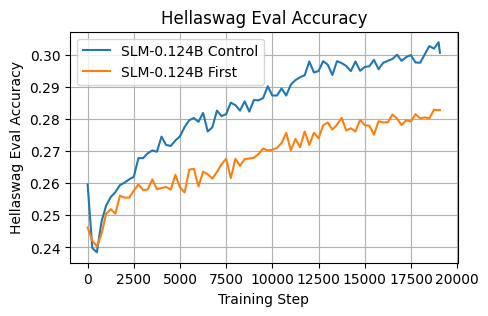

In [11]:
plt.figure(figsize=(3, 1))

plt.plot(control_hella["index"], control_hella["value"], label="SLM-0.124B Control")
plt.plot(first_hella["index"], first_hella["value"], label="SLM-0.124B First")

plt.xlabel('Training Step')
plt.ylabel('Hellaswag Eval Accuracy')
plt.title('Hellaswag Eval Accuracy')
plt.legend()
plt.grid(True)

## Hella Swag Eval

The hellaswag eval methodology was based on Andrej Karpathy's implementation. Because the models are so small, they do not have the reasoning ability to be shown a list of choices and pick a result, so instead, probability comparisons are used. The model is independently called four times, one for each multiple-choice answer, and the probabilities the model assigns to each choice are evaluated to confirm what result the model chose.

| Model    | HellaSwag |
| -------- | -------   |
| Olmo 7B  | 0.7338     | 
| Olmo 1B | 0.6071     |
| GPT-2 1.5B    |  0.4839   |
| GPT-2 124M    | 0.2955    |
| Qwen2.5-1.5B    | 0.6469    |

These results motivate the idea for this test. These larger models have significantly higher hellaswag scores, especially given the fact that a random result would be ~0.25. The work of Yuxian et al. shows that for larger models (1B-7B), getting knowledge distilled into them is quite fruitful, and their methodology of reverse KLD is good at doing so. I will test if these results hold for even smaller models (124M).

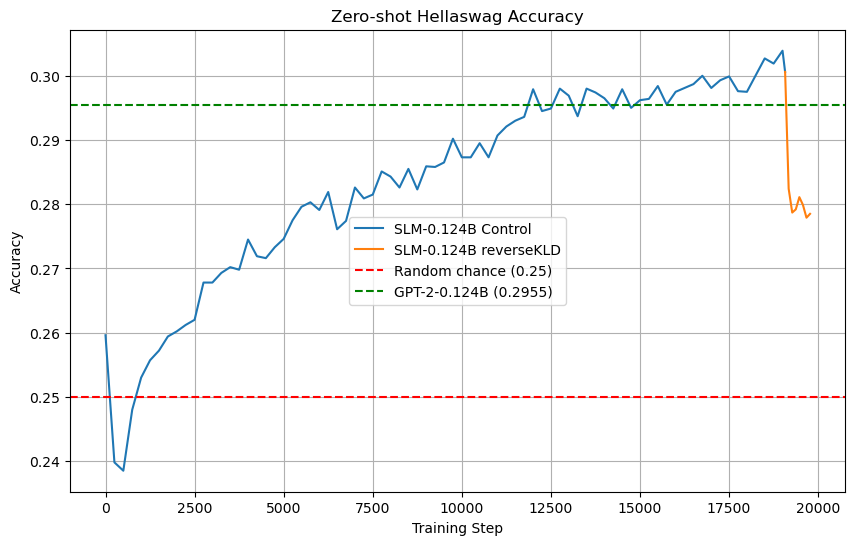

In [3]:
plt.figure(figsize=(10, 5))

rkld_hella_idx = rkld_hella["index"] + max(control_hella["index"])

plt.plot(control_hella["index"], control_hella["value"], label="SLM-0.124B Control")
# plt.plot(hella_data_first["value"], label="SLM-0.124B First")
plt.plot(rkld_hella_idx, rkld_hella["value"], label="SLM-0.124B reverseKLD")
plt.xlabel('Training Step')
plt.ylabel('Accuracy')
plt.title('Zero-shot Hellaswag Accuracy')

# Add a dotted line at y = 0.25 for random chance accuracy
plt.axhline(y=0.25, color='red', linestyle='--', label='Random chance (0.25)')
plt.axhline(y=0.2955, color='green', linestyle='--', label='GPT-2-0.124B (0.2955)')

plt.legend()
plt.grid(True)

The plot shows that the control model outperforms the 124M checkmark of GPT-2 using improved training methods and data.  

The reverse KLD training process was computationally expensive. You would have to evaluate all data twice, once through a much larger model, so the training process was much slower. The model training method was tested with a variety of hyperparameters (length, alpha, lr), but all changes had similar results. The model did not generalize well and got worse. 

I believe these results occur because the model size is too small. I think the idea of superposition may have much to do with this. It is believed, via the concept of superposition, that the number of facts that can be stored goes up exponentially with parameter size because the number of "directions" that can be linked to characteristics rises exponentially with dimension. Even with the high level of smoothing, the smaller model could not generalize the results in any meaningful way because the larger training models have a significant amount of context for such a small model to absorb.

### Citation:


[1] Biao Zhang, & Rico Sennrich. (2019). Root Mean Square Layer Normalization.

[2] Yuxian Gu, undefined., et al, "MiniLLM: Knowledge Distillation of Large Language Models," 2024.

[3] J. Thompson, “On the Disparity Between Swish and GELU - Towards Data Science,” Medium, Mar. 03, 2021. https://towardsdatascience.com/on-the-disparity-between-swish-and-gelu-1ddde902d64b.
‌